# Denoising Dirty Documents: A Tale of Two Models

This notebook will ostensibly be about solving the Kaggle challenge of [Denoising Dirty Documents](https://www.kaggle.com/c/denoising-dirty-documents). Really, though, it is to allow us to try our hand at learning Theano to build neural networks by following the [deeplearning.net tutorials](http://deeplearning.net/reading-list/tutorials/) and comparing our results to the always popular random forest approach.

Let's begin by importing a whole slew of libraries as well as setting a random seed. Don't worry too much about the libraries for now. You will see how they are used later in the code.

In [41]:
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
import numpy as np
import theano
import theano.tensor as T
import cv2
import os
import itertools
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import gzip
import cPickle
from sklearn.externals import joblib
import timeit

import pylab
from PIL import Image
import matplotlib.cm as cm

%matplotlib inline
rng = np.random.RandomState(12345)
np.random.seed(1234)
theano.config.floatX = 'float32'

## Exploratory Data Analysis

Our first job is to get a grip on the data we're provided. We've already downloaded the data via the Kaggle website to our './data' folder. So let's take a look at some of the noise that we're being asked to remove.

In [2]:
def display_two_images(im_1, im_2):
    f = pylab.figure(figsize = (20,10))
    for n,im in enumerate([im_1,im_2]):
        f.add_subplot(1, 2, n+1)
        fig = pylab.imshow(im,cmap=cm.Greys_r)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [3]:
def display_dirty_and_clean(fname):
    dirty_im = Image.open('./data/train/' + fname,'r')
    clean_im = Image.open('./data/train_cleaned/' + fname,'r')
    display_two_images(dirty_im, clean_im)

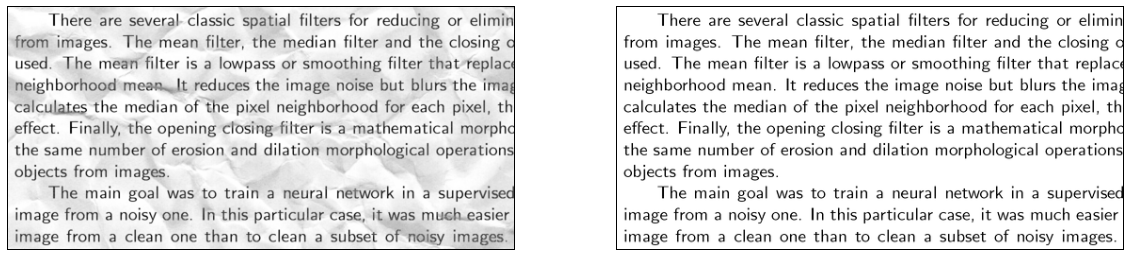

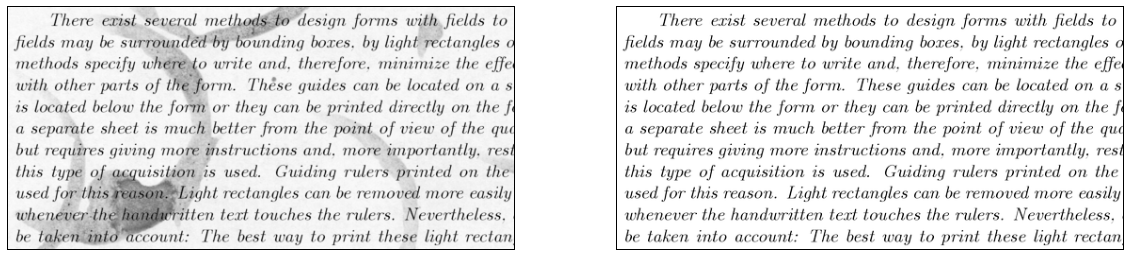

In [50]:
for fname in ['48.png', '2.png']:
    display_dirty_and_clean(fname)

From looking through the training set, we see that two passages of text appear, repeated several times with the font changed and with about 5 different methods of adding noise. We also notice that the test set has a different text passage, but similar noise patterns.

## Processing the Inputs and Outputs

We now write some functions to load our dataset into this notebook to be used by our machine learning models. To do this we must first decide on what features we'd like to extract. We'll begin by taking a relatively naive feature selection and simply take a 5x5 window around each pixel as the input set to try to determine the brightness of that pixel. Notice that this massively increases the effective size of our training set!

To create this feature set and target set, we will use the OpenCV library as suggested by Rangel Dokov.

In [42]:
def load_image(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

In [43]:
def feature_matrix(img):
    window = (5,5)
    nbrs = [cv2.getRectSubPix(img, window, (y,x)).ravel() for x,y in itertools.product(range(img.shape[0]), range(img.shape[1]))]
    
    features = np.asarray(nbrs)
    return (features/255.0).astype('float32')

In [44]:
def target_matrix(img):
    return (img/255.0).astype('float32').ravel()[:,None]

In [45]:
def load_train_set(file_list):
    xs = []
    ys = []
    for fname in file_list:
        xs.append(feature_matrix(load_image(os.path.join('./data/train/', fname))))
        ys.append(target_matrix(load_image(os.path.join('./data/train_cleaned/', fname))))
        
    return np.vstack(xs), np.vstack(ys)

We are now ready to load our training set and split off a chunk of it to act as a validation set against which we can test the quality of our algorithms.

In [ ]:
all_images = os.listdir('./data/train')
np.random.shuffle(all_images)

train_images = all_images[:int(0.8*len(all_images))]
valid_images = all_images[int(0.8*len(all_images)):]
    
train_x, train_y = load_train_set(train_images)

We write a function to compute the Root Mean Square Error that our prediction functions achieve on the validation set. 

In [47]:
def validation_error(valid_images, prediction):
    RMSE = 0
    for fname in valid_images:
        img_x, img_y = load_train_set([fname])
        img_pred = prediction(img_x)
        img_y = img_y.ravel()
        img_pred = img_pred.ravel() 
        RMSE += np.sqrt(np.mean((img_y - img_pred)**2))
    RMSE = RMSE / len(valid_images)
    return RMSE

Finally we write some functions to process our test set predictions. The first two take the test set images and create a data frame of predictions in the form required by Kaggle and then write these to a csv.gzip. The latter take a test image and displays the cleaned version under both our neural network prediction and our random forest prediction.

In [48]:
def submission_df_from_test_files(test_file_list, prediction):
    num_test_files = len(test_file_list)-1
    i = 0
    submission_df = pd.DataFrame(columns = ["id", "value"])
    for fname in test_file_list:
            if not fname.startswith('.'):
                i = i+1
                if i%5==0:
                    print 'Working on file %i/%i' % (i, num_test_files)

                test_image = load_image(os.path.join('./data/test/', fname))
                test_x = feature_matrix(test_image)        

                y_pred = prediction(test_x)
                size = test_image.shape
                output = y_pred.reshape(size)

                image_number = fname.split(".")[0]
                image_df = pd.DataFrame([(x+1, y+1) for x in range(size[0]) for y in range(size[1])], columns = ["row", "col"])
                image_df['value'] = output[image_df.row-1, image_df.col-1]
                image_df['id'] = image_number + "_" + image_df.row.astype('str') + "_" + image_df.col.astype('str')

                submission_df = submission_df.append(image_df[['id','value']])
    return submission_df    

In [49]:
def double_submission_df_from_test_files(test_file_list, prediction1, prediction2):
    num_test_files = len(test_file_list)-1
    i = 0
    submission_df = pd.DataFrame(columns = ["id", "value"])
    for fname in test_file_list:
            if not fname.startswith('.'):
                i = i+1
                if i%5==0:
                    print 'Working on file %i/%i' % (i, num_test_files)

                test_image = load_image(os.path.join('./data/test/', fname))
                test_x = feature_matrix(test_image)        

                y_pred = prediction1(test_x)
                size = test_image.shape
                output = y_pred.reshape(size)
                output = np.float32(output)
                
                input_2 = feature_matrix(output)
                y_pred_2 = prediction2(input_2)
                output_2 = y_pred_2.reshape(size)*255.0

                image_number = fname.split(".")[0]
                image_df = pd.DataFrame([(x+1, y+1) for x in range(size[0]) for y in range(size[1])], columns = ["row", "col"])
                image_df['value'] = output_2[image_df.row-1, image_df.col-1]
                image_df['id'] = image_number + "_" + image_df.row.astype('str') + "_" + image_df.col.astype('str')

                submission_df = submission_df.append(image_df[['id','value']])
    return submission_df    

In [50]:
def write_to_csv_gzip(submission_df):
    with gzip.open('./outputs/submission.csv.gzip', 'wt') as write_file:
        submission_df.to_csv(write_file, index = False)
    print "...csv is done!"

In [ ]:
def cleaned_test_image(fname, prediction):
    #??

## Building a Neural Network

We're finally able to start building our machine learning models! Our first model will be a multilayer perceptron (MLP) neural network that we're going to build using the Theano library.

We begin by defining a class "Layer" that will hold the weights and activation functions between layers on the network. Using Theano, we create symbolic variables for the weights of the network and initialize them randomly. We then use our activation function to compute the output of the network to the next layer. Finally, we specify the parameters of the layer that will be changed as we train our network.

In [51]:
class Layer(object):
    def __init__(self, inputs, rng, n_in, n_out, W=None, b=None, activation = T.tanh):
        if W is None:
            W_values = np.asarray(
                rng.uniform(
                low = -np.sqrt(6. / (n_in + n_out)),
                high = np.sqrt(6. / (n_in + n_out)),
                size = (n_in, n_out)    
                ),
                dtype = theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4
            W = theano.shared(value = W_values, name = 'W', borrow = True)
        
        if b is None:
            b_values = np.zeros((n_out,), dtype = theano.config.floatX)
            b = theano.shared(value = b_values, name = 'b', borrow = True)
        
        self.input = inputs
        self.W = W
        self.b = b
        lin_output = T.dot(inputs, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        self.params = [self.W, self.b]

The MLP class now puts together two layers into a simple multilayer perceptron network. This network has an input layer, one hidden layer, and an output layer. These are specified using two instances of our Layer class. We again specify the parameters, input, and output of this network. Finally, we define the cost function that we are trying to minimize (in this case root mean squared error).

In [34]:
class MLP(object):
    def __init__(self, rng, inputs, n_in, n_hidden, n_out):
        self.hiddenLayer = Layer(
            rng = rng,
            inputs = inputs,
            n_in = n_in,
            n_out = n_hidden,
            activation = T.tanh
        )
        
        self.logRegressionLayer = Layer(
            rng = rng,
            inputs = self.hiddenLayer.output,
            n_in = n_hidden,
            n_out = n_out,
            activation = T.nnet.sigmoid
        )
        
        self.params = self.hiddenLayer.params + self.logRegressionLayer.params
        
        self.input = inputs
        
        self.output = self.logRegressionLayer.output
        
    def cost(self,y):
        return T.mean((self.output - y)**2)

In [29]:
class deep_MLP_clip(object):
    def __init__(self, rng, inputs, n_in, n_hidden_1, n_hidden_2, n_out):
        self.hiddenLayer1 = Layer(
            rng = rng,
            inputs = inputs,
            n_in = n_in,
            n_out = n_hidden_1,
            activation = T.tanh
        )
        
        self.hiddenLayer2 = Layer(
            rng = rng,
            inputs = self.hiddenLayer1.output,
            n_in = n_hidden_1,
            n_out = n_hidden_2,
            activation = T.tanh
        )
        
        self.logRegressionLayer = Layer(
            rng = rng,
            inputs = self.hiddenLayer2.output,
            n_in = n_hidden_2,
            n_out = n_out,
            activation = lambda x: T.clip(x,0.0,0.5)
        )
        
        self.params = self.hiddenLayer1.params + self.hiddenLayer2.params + self.logRegressionLayer.params
        
        self.input = inputs
        
        self.output = self.logRegressionLayer.output
        
    def cost(self,y):
        return T.mean((self.output - y)**2)

We now define a function to train our MLP on a training set. Here, we use Theano's functionality to compute the gradient of the cost function with respect to our parameters and used these to define how we will update our weights using the stochastic gradient descent algorithm. Finally we, loop through our data set in batches and apply our updates for a fixed number of epochs.

In [52]:
def mlp_train(mlp, training_set, batch_size, learning_rate, n_epochs):
    train_x, train_y = training_set
    
    n_train_batches = train_x.shape[0] // batch_size
    x = mlp.input
    y = T.matrix('y')
    
    gparams = [T.grad(mlp.cost(y), param) for param in mlp.params]
    updates = [(param, param - learning_rate*gparam) for param,gparam in zip(mlp.params, gparams)]
    
    train_model = theano.function(
        inputs = [x,y],
        outputs = [],
        updates = updates
    )
    
    for epoch in xrange(n_epochs):
        if (epoch+1)%10 == 0:
            print 'Epoch %i out of %i' % (epoch + 1, n_epochs)
        for index in range(n_train_batches):
            #if index%100000 == 0:
            #    print 'Batch %i out of %i' % (index + 1, n_train_batches)
            batch = list(range(index*batch_size, (index+1)*batch_size))
            train_model(train_x[batch], train_y[batch])

A prediction function that simply returns the predicted image from our input.

In [53]:
def mlp_predict(mlp, predict_x):
    x = mlp.input
    predict = theano.function(
        inputs = [x],
        outputs = [mlp.output]
    )
    
    predict_y, = predict(predict_x)
    return predict_y

We're now ready to train our first neural network. Let's start by specifying some standard values for the size of the hidden layer, number of epochs, batch_size, and learning rate. Later, we'll try adjusting these values to see how much they affect the result.

In [36]:
n_hidden = 10
batch_size = 20
n_epochs = 10
rate = 0.1

x = T.matrix('x')

Let's try training our first neural network and see how it does!

In [ ]:
mlp = MLP(
    rng = rng,
    inputs = x,
    n_in = train_x.shape[1],
    n_hidden = n_hidden,
    n_out = 1
)

In [ ]:
mlp_train(mlp, (train_x, train_y), batch_size = batch_size, n_epochs = n_epochs, learning_rate = rate) 
v_error = validation_error(valid_images, lambda x: mlp_predict(mlp,x))
print 'Validation error is %.4f' % error

We are able to achieve a validation error of ... which is not bad. Perhaps we can improve this by adjusting some of the hyperparameters. Let's first try training the model for longer, by increasing the number of epochs.

After every 10 epochs we'll record the time it took to train, the validation error, and also save a copy of the model using cPickle for later use.

In [ ]:
def range_over_epochs(n_epochs_per_batch, n_batches, mlp, mlp_label):
    model_df = pd.DataFrame(columns = ["n_epochs", "validation_error", "training_time_minutes"])
    for batch in xrange(n_batches):
        tot_epochs = (batch+1)*n_epochs_per_batch
        start_time = timeit.default_timer()
        mlp_train(mlp, (train_x, train_y), batch_size = batch_size, n_epochs = n_epochs_per_batch, learning_rate = rate) 
        end_time = timeit.default_timer()
        v_error = validation_error(valid_images, lambda x: mlp_predict(mlp,x))
        fname = '%s_%i_epochs.pkl' % (mlp_label,tot_epochs) 
        df = pd.DataFrame({"n_epochs": [tot_epochs], "validation_error": [v_error], "training_time_minutes": [(end_time-start_time)/60]})
        model_df = model_df.append(df)
        with open('./models/' + fname, 'w') as f:
                cPickle.dump(mlp, f)
    return model_df

In [ ]:
# Warning this cell can take several hours to compute!

mlp = MLP(
    rng = rng,
    inputs = x,
    n_in = train_x.shape[1],
    n_hidden = n_hidden,
    n_out = 1
)
mlp_epochs_df = range_over_epochs(n_epochs_per_batch = 10, n_batches = 10, mlp = mlp, mlp_label="mlp")

We write to a file as training and generating this data is a time consuming process. We will reload this file to perform our analysis.

In [ ]:
with open('./outputs/mlp_epoch_training_data.csv', 'wt') as write_file:
        mlp_epochs_df.to_csv(write_file, index = False)

In [9]:
mlp_epochs_df = pd.read_csv('./outputs/mlp_epoch_training_data.csv')
mlp_epochs_df

,n_epochs,training_time_minutes,validation_error
0,10,11.530481,0.031142
1,20,11.514739,0.029887
2,30,11.367349,0.029589
3,40,11.292501,0.029448
4,50,11.457089,0.029342
5,60,11.368617,0.029278
6,70,11.916523,0.029237
7,80,13.371353,0.029209
8,90,11.159621,0.029190
9,100,10.987097,0.029176


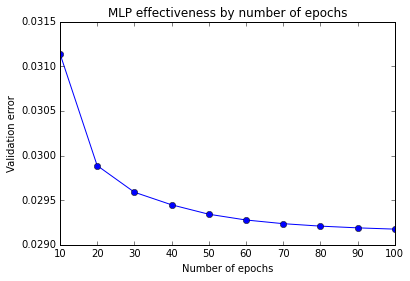

In [14]:
pylab.plot(mlp_epochs_df.n_epochs,mlp_epochs_df.validation_error, 'ob-')
pylab.xlabel('Number of epochs')
pylab.ylabel('Validation error')
pylab.title('MLP validation error by number of epochs')

So, we see that the efficiency improves quickly after training for the first 30 or 40 epochs before levelling off near 90 or 100 epochs. Training a network for 100 epochs should be enough to capture most of its effectiveness and takes about two hours.

Next, let's see how the structure of the hidden layer might affect the efficacy of our MLP. We'll test hidden layers of size ranging from 15 neurons to 10 to see if we can decipher what an optimal size should be. Again, we store the validation error and training times. We'll also store the best of these models using cPickle.



In [ ]:
# Warning this cell can take several hours to compute!

mlp_hidden_df = pd.DataFrame(columns = ["n_hidden", "validation_error","training_time_minutes"])
best_validation_error = np.inf
best_n = 0
for n_hidden in xrange(15,9,-1):
    
    mlp = MLP(
        rng = rng,
        inputs = x,
        n_in = train_x.shape[1],
        n_hidden = n_hidden,
        n_out = 1
    )
    
    start_time = timeit.default_timer()
    mlp_train(mlp, (train_x, train_y), batch_size = batch_size, n_epochs = n_epochs, learning_rate = rate) 
    end_time = timeit.default_timer()
    v_error = validation_error(valid_images, lambda x: mlp_predict(mlp,x))
    
    df = pd.DataFrame({"n_hidden": [n_hidden], "validation_error": [v_error], "training_time_minutes": [(end_time-start_time)/60]})
    mlp_hidden_df = mlp_hidden_df.append(df)
    
    if v_error < best_validation_error:
        best_validation_error = v_error
        best_n = n_hidden
        with open('./models/best_mlp_model.pkl', 'w') as f:
            cPickle.dump(mlp, f)
with open('./outputs/mlp_hidden_layer_training_data.csv', 'wt') as write_file:
        mlp_model_df.to_csv(write_file, index = False)

In [19]:
mlp_hidden_df = pd.read_csv('./outputs/mlp_hidden_layer_training_data.csv')
mlp_hidden_df

,n_hidden,training_time_minutes,validation_error
0,15,114.891871,0.029945
1,14,114.156975,0.029239
2,13,113.739772,0.029069
3,12,109.183398,0.029102
4,11,111.115079,0.029449
5,10,109.023519,0.029339


In [1]:
pylab.plot(mlp_hidden_df.n_hidden, mlp_hidden_df.validation_error, 'ob-')
pylab.xlabel('Number of hidden neurons')
pylab.ylabel('Validation error')
pylab.title('MLP validation error by number of hidden neurons')

NameError: name 'pylab' is not defined

So, while 13 neurons has the lowest validation error, it seems to not make a big difference over 10. Ultimately, more experimentation would be needed to fix on an optimal number of neurons in the hidden layer.

Instead of building wider networks, what if we tried to build deeper ones? Let's try training some multilayer networks to see how they affect the effectiveness of the MLP.

In [54]:
class deep_MLP(object):
    def __init__(self, rng, inputs, n_in, num_hidden_layers, n_hidden_vec, n_out):
        
        self.hiddenLayers = [Layer(
                rng = rng,
                inputs = inputs,
                n_in = n_in,
                n_out = n_hidden_vec[0],
                activation = T.tanh
            )]
        for i in xrange(1,num_hidden_layers):
            self.hiddenLayers.append(Layer(
                    rng = rng,
                    inputs = self.hiddenLayers[i-1].output,
                    n_in = n_hidden_vec[i-1],
                    n_out = n_hidden_vec[i],
                    activation = T.tanh                
                ))
        
        self.logRegressionLayer = Layer(
            rng = rng,
            inputs = self.hiddenLayers[num_hidden_layers-1].output,
            n_in = n_hidden_vec[num_hidden_layers-1],
            n_out = n_out,
            activation = T.nnet.sigmoid
        )
        
        self.params = self.logRegressionLayer.params
        for i in xrange(num_hidden_layers):
            self.params += self.hiddenLayers[i].params
        
        self.input = inputs
        
        self.output = self.logRegressionLayer.output
        
    def cost(self,y):
        return T.mean((self.output - y)**2)

We're going to train MLP's with two layers of hidden neurons and three layers of hidden neurons over a range of epochs.

In [ ]:
a_2_deep_mlp = deep_MLP(
    rng = rng,
    inputs = x,
    n_in = n_in,
    num_hidden_layers = 2,
    n_hidden_vec = [10,5],
    n_out = 1
)

a_3_deep_mlp = deep_MLP(
    rng = rng,
    inputs = x,
    n_in = n_in,
    num_hidden_layers = 3,
    n_hidden_vec = [10,5,3],
    n_out = 1    
)

In [ ]:
# Warning this cell can take several hours to compute!

a_2_deep_mlp_epochs_df = range_over_epochs(n_epochs_per_batch = 10, n_batches = 10, mlp = 2_deep_mlp, mlp_label="2_deep_mlp")
a_3_deep_mlp_epochs_df = range_over_epochs(n_epochs_per_batch = 10, n_batches = 10, mlp = 3_deep_mlp, mlp_label="3_deep_mlp")

Again, we save these dataframes as csv's so that we can reload them later without retraining our MLP's.

In [ ]:
with open('./outputs/2_deep_mlp_epoch_training_data.csv', 'wt') as write_file:
        a_2_deep_mlp_epochs_df.to_csv(write_file, index = False)
with open('./outputs/3_deep_mlp_epoch_training_data.csv', 'wt') as write_file:
        a_3_deep_mlp_epochs_df.to_csv(write_file, index = False)

In [63]:
a_2_deep_mlp_epochs_df = pd.read_csv('./outputs/2_deep_mlp_epoch_training_data.csv')
a_3_deep_mlp_epochs_df = pd.read_csv('./outputs/3_deep_mlp_epoch_training_data.csv')

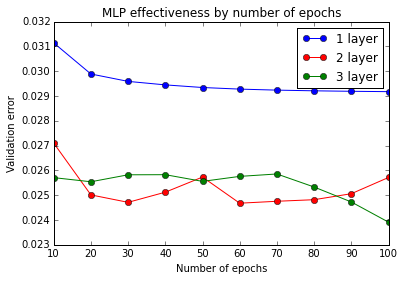

In [65]:
pylab.plot(mlp_epochs_df.n_epochs,mlp_epochs_df.validation_error, 'ob-', label="1 layer")
pylab.plot(a_2_deep_mlp_epochs_df.n_epochs,a_2_deep_mlp_epochs_df.validation_error, 'or-', label="2 layer")
pylab.plot(a_3_deep_mlp_epochs_df.n_epochs,a_3_deep_mlp_epochs_df.validation_error, 'og-', label="3 layer")
pylab.legend(loc='upper right')
pylab.xlabel('Number of epochs')
pylab.ylabel('Validation error')
pylab.title('MLP validation error by number of epochs')

So, we see that increasing the depth of the neural network leads to a significant improvement in outcomes. 

Alright, let's submit our 3 layer deep, 100 epoch trained neural network and see how we do!

In [ ]:
a_3_deep_mlp = 

In [15]:
test_files = os.listdir('./data/test')

In [16]:
submission_df = submission_df_from_test_files(test_files, lambda x: mlp_predict(mlp,x))

Working on file 5/72
Working on file 10/72
Working on file 15/72
Working on file 20/72
Working on file 25/72
Working on file 30/72
Working on file 35/72
Working on file 40/72
Working on file 45/72
Working on file 50/72
Working on file 55/72
Working on file 60/72
Working on file 65/72
Working on file 70/72


In [17]:
write_to_csv_gzip(submission_df)

...csv is done!


Upon submission to Kaggle, we scored xxx which gave us a leaderboard score of yyy. Can we improve on this?

## A Simple Random Forest Model

In deciding to tackle the image denoising process on a pixel-by-pixel level, what we really have for each pixel is a regression task with twenty-five input data points for each output data point. Thus, we can use any machine learning model that is appropriate for regression.

Let's see what happens if we use a random forest regressor with 15 estimators. Again we save the model to a file for later use to avoid long training times.

In [ ]:
# Warning this cell can take several hours to compute!
n_estimators = 15

start_time = timeit.default_timer()
rf = RandomForestRegressor(n_estimators = n_estimators, n_jobs = 2)
rf.fit(train_x, train_y.ravel())
end_time = timeit.default_timer()

v_error = validation_error(valid_images, rf.predict)
rf_model_df = pd.DataFrame({"n_estimators": [n_estimators], "validation_error": [v_error], "training_time_minutes": [(end_time-start_time)/60]})
joblib.dump(rf, './models/best_rf_model.pkl')
with open('./outputs/rf_training_data.csv', 'wt') as write_file:
        rf_model_df.to_csv(write_file, index = False)

In [ ]:
rf_model_df = pd.read_csv('./outputs/rf_training_data.csv') 

In [ ]:
print 'The random forest model with %i estimators achieved a validation error of %.4f in %.2f minutes of training.' % (rf_model_df.n_estimators[0], rf_model_df.validation_error[0], rf_model_df.training_time_minutes)

The random forest model knocks it out of the park - achieving a much lower validation error than even the 3-layer neural network!

We will now load the model from a file and use it to denoise the test data and create a submission.

In [ ]:
rf = joblib.load('./models/rf_model.pkl') 

In [18]:
#test_files = ['4.png', '82.png']
test_files = os.listdir('./data/test')

submission_df = submission_df_from_test_files(test_files, rf.predict) ##using double function

Working on file 5/72
Working on file 10/72
Working on file 15/72
Working on file 20/72
Working on file 25/72
Working on file 30/72
Working on file 35/72
Working on file 40/72
Working on file 45/72
Working on file 50/72
Working on file 55/72
Working on file 60/72
Working on file 65/72
Working on file 70/72


Make output csv.gzip

In [19]:
write_to_csv_gzip(submission_df)

...csv is done!


This submission achieves a test error of xxxx and a leaderboard rank of yyyy. It turns out random forests are a pretty good approach to this problem.

## Further Improvements

So, we managed to place in the top 10 on the leaderboard. Now, let's set our sights to top five. Here are a few tricks we might try to make the necessary improvement in our score:

* **Second pass filters:** We can train a second random forest to take the output of our first random forest as input and try to achieve more detailed filtering. This second filter works with a far simplified image and may be able to better distinguish the underlying letters.
* **Better feature selection:** Instead of just looking at a 5x5 window around a pixel, we might look at other features. One approach, for example, would be to preprocess our image with some edge detection algorithms.
* **Seeding our neural network:** We might look for neural networks that have been used in the past to detect alphanumeric characters in images. By using these as a seed from which our own neural network can fine-tune, we might achieve better results.